# In this notebook the feature generation and passive learning for the Enron dataset is performed

In [ ]:
import pandas as pd                 #For data science purposes
import matplotlib.pyplot as plt     #For plotting
import os
from email.parser import Parser     #For parsing enron emails
from tqdm import tqdm, tqdm_pandas  #For loading bars                   
import re                           #For performing regex
import numpy as np
import torch                        #For running models with cuda
import string
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
import pickle                       #For importing saved variables
from nltk import data, pos_tag
import nltk 
from PassivePySrc import PassivePy  #For detecting passive voice sentences
import enchant                      #For checking english words
from gensim.parsing.preprocessing import remove_stopwords #For removing stopwords
import spacy  
import mmh3
from tensorflow.keras.preprocessing.text import hashing_trick

spacy.prefer_gpu()
                            
tqdm.pandas()

# Folder Path
path = r"enron_with_categories"
  
# Change the directory
os.chdir(path)

emaillist = []
# Read text File
          
# Extract email from a txt file  
def extract_text_from_file(file_path):
    with open(file_path, 'r') as f:
        if file_path.endswith(".txt"):
            data = f.read()
            email = Parser().parsestr(data)
            body = email.get_payload()
            return body
# Extract labels from .cats file 
def extract_labels(file_path):
    with open(file_path, 'r') as f:
        if file_path.endswith(".cats"):
            return(f.read().splitlines())

# By using the above two methods, create a dataframe and extract labels and text from emails. Then concatenate these into one dataframe.        
column_names = ["abstract", "label", "length"]
enron_df = pd.DataFrame(columns = column_names)
for root, dirs, files in os.walk(r"enron_with_categories"):
    for file in files:
        numericlabel, label, email, length, filename = None,None,None,None,None  # Create empty variables for storing results
        if file.endswith('.txt'):
            email = extract_text_from_file(os.path.join(root,file))
            email = ' '.join(email.split()[:len(email.split())])
            length = len(email)
            filename = file.rpartition('.')[0]
            for catfile in files:
                if catfile.endswith('.cats') and catfile.rpartition('.')[0] == file.rpartition('.')[0]:
                    numericlabel = extract_labels(os.path.join(root,catfile))
                    for labelset in numericlabel:
                        if '1,4' in labelset: #This can be changed to import whatever type of label that one would like
                            label = 1
                            break
                        elif not label == 1:
                            label = 0 
            if length < 15000 and length > 15: # Remove very long and short emails
                enron_df = pd.concat([pd.DataFrame.from_records([{'abstract': email, 'label': label, 'length' : length, 'title' : filename}]), enron_df], ignore_index=True)
        
enron_df = enron_df.astype({'label': 'int64'})

In [ ]:
# Import and download NLTK packages
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words
from nltk.corpus import stopwords

# Download required NLTK packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Feature generation


## Sentiment values

In [107]:
# Import model and tokenizer for sentiment analysis
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english" ) # Load in model for sentiment analysis
model.eval() # Make sure model is not in training mode anymore
tokenizernlp = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", model_max_len=512) # Load in tokenizer and set max_len to 512 as graphics card can't handle more than that

In [108]:
# Perform sentiment analysis on all rows
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
sentiment_analysis = pipeline("sentiment-analysis" , model=model, tokenizer = tokenizernlp, device = 0) # Create pipeline for performing sentiment analysis
def generatesentimentvalues(text):
    sentiment_result = sentiment_analysis(text, **tokenizer_kwargs) # perform sentiment analysis on text
    if sentiment_result[0]['label'] == 'NEGATIVE': # As we can only use numbers for the final model, we need to transform the results from numbers with a label to purely numbers
        result = 0-sentiment_result[0]['score']
    else:
        result = sentiment_result[0]['score']
    return result
enron_df['sentiment_score'] = enron_df.abstract.progress_apply(lambda x: generatesentimentvalues(x)) #Apply sentiment analysis on dataframe 

  1%|          | 11/1597 [00:00<01:27, 18.13it/s]C:\Users\MichaG\Anaconda3\lib\site-packages\transformers\pipelines\base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1597/1597 [01:28<00:00, 18.13it/s]


## Named Entity Recognition

In [ ]:
# Import model and tokenizer for named entity recognition
modelner = AutoModelForTokenClassification.from_pretrained('xlm-roberta-large-finetuned-conll03-english', return_dict=True)
modelner.eval()
#modelner = modelner.to("cuda:0")

tokenizerner = AutoTokenizer.from_pretrained('xlm-roberta-large-finetuned-conll03-english')

In [66]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

def generate_named_entities(text):
    ''' Function that generates named entity values for the inputted text.
    This Method does a few things. First it splits the text into single sentences(split_into_senteces). The short sentences are then removed based on the average length of the sentences in the text(remove_short_tokens)
    The tokens are then fed into a tokenizer and the generated tokens are fed into a model that generates named entities based on the tokens. The result of this is returned as a dict which can then be appended to the dataframe.
    them to the dataframe and removing the old one.
    '''
    tokens = [x for x in split_into_sentences(text) if not any(y in x for y in ['/','+'])] # split text into sentences and remove any sentence that contains / or + as a character
    tokens = remove_short_tokens(tokens)
    if tokens:
        inputs = tokenizerner.batch_encode_plus(tokens, return_tensors="pt", padding = True, max_length = 512, truncation = True) # tokenize sentences, max_length is 512 for if cuda is enabled to speed the model up
        with torch.no_grad():
            results = modelner(**inputs)
            for i, input in enumerate(inputs['input_ids']):
                namedentities = [modelner.config.id2label[item.item()] for item in results.logits[i].argmax(axis=1)] #for every probability for a named entity for a word, turn the probabilities into their associated labels
        entitynumberlist = generate_entity_list(namedentities) #Based on the array of entity names that is generated, count each entity and make a dict of this
    else:
        entitynumberlist = {'B-LOC': 0, 'B-MISC': 0, 'B-ORG' : 0, 'I-LOC' : 0, 'I-MISC': 0, 'I-ORG': 0, 'I-PER': 0}
    return entitynumberlist

def remove_short_tokens(tokens):
    average = 0
    for token in tokens:
        average += len(token)
    try:      
        average = average/len(tokens)
        return([x for x in tokens if len(x) >= average])
    except:
        return(tokens)
    
def generate_entity_list(entities):
    B_LOC, B_MISC, B_ORG, I_LOC, I_MISC, I_ORG, I_PER = 0,0,0,0,0,0,0
    for entity in entities:    
        if entity == 'B-LOC':
            B_LOC += 1
        elif entity == 'B-MISC':
            B_MISC += 1
        elif entity == 'B-ORG':
            B_ORG += 1
        elif entity == 'I-LOC':
            I_LOC += 1
        elif entity == 'I-MISC':
            I_MISC += 1
        elif entity == 'I-ORG':
            I_ORG += 1
        elif entity == 'I-PER':
            I_PER += 1
    return({'B-LOC': B_LOC, 'B-MISC': B_MISC, 'B-ORG': B_ORG, 'I-LOC': I_LOC, 'I-MISC': I_MISC, 'I-ORG':I_ORG, 'I-PER':I_PER})

In [ ]:
#Gnerate seperate named entity recognition dataframe that contains all entities found in the texts
col_names_entity_df1 =  ["B-LOC", "B-MISC", "B-ORG", "I-LOC", "I-MISC", "I-ORG", "I-PER"]
entity_df1 = pd.DataFrame(columns = col_names_entity_df1)
entity_df1 = entity_df1.append({'B-LOC': 0, 'B-MISC': 0, 'B-ORG' : 0, 'I-LOC' : 0, 'I-MISC': 0, 'I-ORG': 0, 'I-PER': 0},ignore_index = True)
#entity_df1 = entity_df1.append(enron_df.abstract.progress_apply(lambda x: generate_named_entities(x)), ignore_index = True) 
entity_df1.head()

In [ ]:
#Since the structure of the previous dataframe went wrong, extract the information of the dataframe and put it into a proper dataframe
col_names_entity_df2 =  ["B-LOC", "B-MISC", "B-ORG", "I-LOC", "I-MISC", "I-ORG", "I-PER"]
entity_df2 = pd.DataFrame(columns = col_names_entity_df2)
for column in entity_df1:
    entity_df2 = entity_df2.append(entity_df1.iloc[0][column], ignore_index=True)

entity_df2['filename'] = enron_df.filename
enron_df = pd.merge(enron_df, entity_df2, on='filename', how='inner')
enron_df[1:20]

In [224]:
# Since the named entity recognition is very slow on the cpu, and is too big for the gpu, a saved version of the variable is loaded in using pickle and appended to the original dataframe.
with open(r'NERframe.txt', 'rb') as f:
    entity_df = pickle.load(f)

enron_df = pd.merge(enron_df, entity_df, left_on='title', right_on='filename', how='inner')

## Other features

### Specific words

In [99]:
def specific_words_check(text):
    ''' Function that searches for specific words and sums the total occurences
    '''
    amount_of_words = len(re.findall(r'(\b[Mm]+eet?(ing)?s?\b|\b[Pp]+lane\b|\bexpense report\b|\b[Cc]+all\b|\b[Vv]+oicemail\b|\b[Ee]+?[Mm]+ail(ing)?\b|\b[Ww]+eeks\b|\b([Ss]+chedul(e)?(ing)?)|\b[Tt]+ime|\b[Ww]+eek\b|\b[Ii]+nvite?d?(ing)?\b|\b([0-1]?[0-9]):[0-5][0-9]\b)', text))
    if amount_of_words:
        return(amount_of_words)
    else:
        return 0

In [100]:
enron_df['specific_words_counter'] = enron_df.abstract.apply(lambda x: specific_words_check(x)) #apply the previous function using a lambda statement to create a new column

### Standard deviation of sentence lengths

In [109]:
def standard_dev_sentence_length(text):
    ''' Function that calulates the standard deviation of the length of all the sentences in a text.
    '''
    sentences = nltk.tokenize.sent_tokenize(text)
    sentence_length = []
    for item in sentences:
        sentence_length.append(len(item))
    return(np.std(sentence_length))

In [110]:
enron_df['stdev_sentence_length'] = enron_df.abstract.progress_apply(lambda x: standard_dev_sentence_length(x))

100%|██████████| 1597/1597 [00:00<00:00, 2860.47it/s]


### Automated readability Index

In [111]:
def readability_index(text):
    ''' Function that calculates the automated readability index of a text.
    '''
    sentences = nltk.tokenize.sent_tokenize(text)
    words = text.count(' ')
    characters = len(text) - words
    try:
        return(4.71*(characters/words) + 0.5*(words/len(sentences)) -21.43)
    except:
        return(0)

In [112]:
enron_df['readability_index'] = enron_df.abstract.progress_apply(lambda x: readability_index(x))

100%|██████████| 1597/1597 [00:00<00:00, 3406.37it/s]


### Standard deviation of word lengths

In [114]:
def standard_dev_word_length(text):
    ''' Function that calculates the standard deviation of the word lengths in a text.
    '''
    words = text.split()
    words_length = []
    for word in words:
        words_length.append(len(word))
    return(np.std(words_length))

In [115]:
enron_df['stdev_word_length'] = enron_df.abstract.progress_apply(lambda x: standard_dev_word_length(x))

100%|██████████| 1597/1597 [00:00<00:00, 10765.24it/s]


### Type Token ratio

In [9]:
def type_token_ratio(text):
    ''' Function that calculates the type token ratio of the text. The type token ratio is the ratio between the toal amount of words and the amount of unique words in a text.
    '''
    unique = set(text.split()) 
    return len(unique)/ len(text.split())

In [10]:
enron_df['type_token_ratio'] = enron_df.abstract.progress_apply(lambda x:type_token_ratio(x))

100%|██████████| 1597/1597 [00:00<00:00, 12163.69it/s]


### Proper nouns

In [ ]:
def proper_nouns(text):
    ''' Function that caclulates how many proper nouns there are in a text. This is done with the help of the NLTK perceptron tagger.
    '''
    tagged_sent = pos_tag(text.split())
    propernouns = [word for word,pos in tagged_sent if pos == 'NNP']
    return len(propernouns)

In [ ]:
enron_df['proper_nouns'] = enron_df.abstract.progress_apply(lambda x: proper_nouns(x))

100%|██████████| 1597/1597 [00:25<00:00, 61.86it/s]


### Passive voice sentences


In [6]:
spacy_model = "en_core_web_lg"
passivepy = PassivePy.PassivePyAnalyzer(spacy_model)

C:\Users\MichaG\Anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
def percentage_passive_voice(text):
    ''' Function that caclulates what percentage of sentences in a text are written in passive voice. This is done using the passivePy package.
    '''
    passive_amount = passivepy.match_text(text, full_passive=True, truncated_passive=True).passive_count.iloc[0]
    sentence_amount = nltk.tokenize.sent_tokenize(text)
    return passive_amount/len(sentence_amount)
enron_df['passive_voice_%'] = enron_df.abstract.progress_apply(lambda x: percentage_passive_voice(x))

100%|██████████| 1597/1597 [02:35<00:00, 10.26it/s]


### Active voice sentences

In [234]:
def percentage_active_voice(text):
    ''' Function that caclulates what percentage of sentences in a text are written in active voice. This is done using the passivePy package.
    '''
    return(1-percentage_passive_voice(text))
enron_df['active_voice_%'] = enron_df.abstract.progress_apply(lambda x: percentage_active_voice(x))

100%|██████████| 1596/1596 [02:03<00:00, 12.94it/s]


### Bag of words

### preprocessing tfidf

In [11]:
def convert_lower_case(text):
    return np.char.lower(text)
def remove_email_adresses(text):
    text = re.sub(r'\S*@\S*\s?', '', str(text))
    return text

In [12]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [13]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [14]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [15]:
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text
def remove_random_words(data):
    data = str(data)
    data = re.sub(r'\b(USL)?(usl)?\b', '', data)
    data = re.sub(r'\b(\.((DOC)?(doc)?))\b', '', data)
    data = re.sub(r'\b(e-mail)\b', '', data)
    data = re.sub(r'(\<div\>)', '', data)
    data = re.sub(r'(\<br\>)', '', data)
    data = re.sub(r'(.*?\.[\w:]+)', '', data)
    data = re.sub(r'\[image\]', '', data)
    #data = re.sub(r'\b3d\b', '', data)
    return data

In [16]:
def remove_numbers_phonenumbers(text):
    ''' Function that remove specific sequences of numbers from a text so that they are not seen as words by the BagofWords feature.
    '''
    text = str(text)
    text = re.sub(r'\b([0-9]{3}-[0-9]{3}-[0-9]{4})\b', '', text) #Remove US phone numbers
    text = re.sub(r'\b([0-1][0-9]\/[0-3][0-9]\/[0-9]{4})\b', '', text) #Removes dates
    text = re.sub(r'\b([0-1]?[0-9]):[0-5][0-9]\b', '', text) #Removes timestamps
    text = re.sub(r'\b\w*\d\w*\b', '', text) #Removes single whitespaces
    return(text)

In [17]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_email_adresses(data)
    data = remove_random_words(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = remove_numbers_phonenumbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = remove_numbers_phonenumbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one

    return data

In [18]:
enron_df_bow = enron_df.copy() #Create copy so that we dont modify the actual dataframe

enron_df_bow.abstract = enron_df.abstract.progress_apply(lambda x: word_tokenize(str(preprocess(x))))

100%|██████████| 1597/1597 [01:36<00:00, 16.55it/s]


In [19]:
DF = {}

for i in range(0,len(enron_df_bow)):
    tokens = enron_df_bow.abstract.iloc[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])

In [20]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [21]:
N = len(enron_df_bow)
doc = 0

tf_idf = {}
df_tfidf = pd.DataFrame({'Doc': pd.Series(dtype='str'),
                   'term': pd.Series(dtype='str'),
                   'value': pd.Series(dtype='float'),
                   'label': pd.Series(dtype='int')})
for i in tqdm(range(0,N)):
    tokens = enron_df_bow.abstract.iloc[i]
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        
        tf_idf[doc, token] = tf*idf
        #df_tfidf.loc[len(df_tfidf)] = [doc,token,tf*idf, enron_df.loc[doc].label]

    doc += 1


100%|██████████| 1597/1597 [00:00<00:00, 1923.99it/s]


In [ ]:
df_tfidf = pd.DataFrame({'Doc': pd.Series(dtype='str'),
                   'term': pd.Series(dtype='str'),
                   'value': pd.Series(dtype='float')})
for key in tf_idf:
    new_row = pd.DataFrame({'Doc':[key[0]], 'term':[key[1]], 'value': [tf_idf[key]]})
    df_tfidf = pd.concat([new_row,df_tfidf.loc[:]]).reset_index(drop=True)

### Bag of words with hashes

### preprocessing bow

In [22]:
enron_df_bow = enron_df.copy()
enron_df_bow['abstract'] = enron_df_bow.abstract.progress_apply(lambda x: preprocess(x))

100%|██████████| 1597/1597 [01:30<00:00, 17.59it/s]


In [23]:
def Hashed_BOW(text, length):
    '''With this function hashes of texts can be generated
    '''
    bow_array = [0]*length
    hashes = hashing_trick(
        text,
        length,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=' ',
        analyzer=None)
    for hash_ in hashes:
        bow_array[hash_] = bow_array[hash_]+1
    
    return bow_array[0:length]


In [24]:
# In this cell a dataframe of all bag of words values is created
BOW_df = pd.DataFrame(columns=[str(i) for i in range(0,1001)])

for i in range(len(enron_df_bow)):
    BOW_values = Hashed_BOW(enron_df_bow.abstract.loc[i], 1001)
    BOW_df.loc[i] = BOW_values

In [25]:
# In this cell the tf-idf values are applied to the bag of words values
for key in tf_idf:
    BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]] = BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]]*tf_idf[key]

C:\Users\MichaG\AppData\Local\Temp\ipykernel_8072\2187400621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]] = BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]]*tf_idf[key]


In [ ]:
enron_df_final = pd.concat((enron_df, BOW_df), axis = 1) #Concatenate the BagOfWords dataframe with the other dataframe


In [18]:
enron_df_final = enron_df.copy() # If no bag of words exist, make the enron_df_final variable a copy of the frame that contained the other features

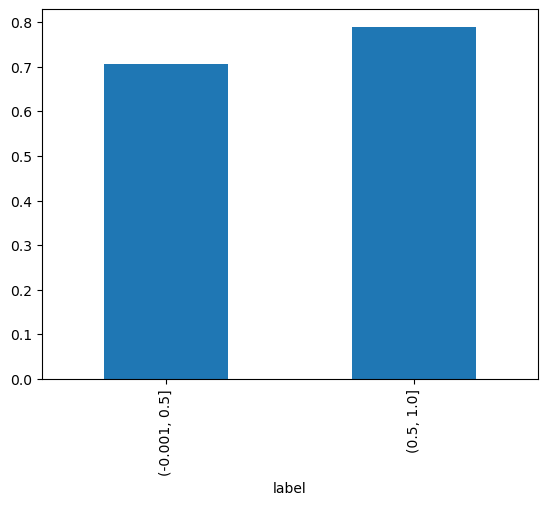

In [ ]:
# With this cell feature histograms for feature selection can be generated
plot = enron_df_final.groupby(pd.cut(enron_df_final.label, bins = 2))['type_token_ratio'].mean().plot.bar()
plot.figure.savefig(r'C:\Users\MichaG\Pictures\Scriptie\typetokenratio.pdf') 

## Creating subset for testing asreview

In [560]:
#By using train test split with the setting stratify we can create a small labeled set in the dataset and a larger unlabeled set which can then be used for active learning in ASReview
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(enron_df_final.drop('label',axis=1), 
                                                    enron_df_final['label'], stratify= enron_df_final['label'], test_size=217, random_state = 29)

enron_df_subset = X_train.copy()
enron_df_subset['label'] = y_train
enron_df_subset1 = X_test.copy()
enron_df_subset1['label'] = np.nan
enron_test_export = pd.concat([enron_df_subset,enron_df_subset1])
enron_test_export = enron_test_export.drop(['length'], axis = 1)

enron_test_export[['abstract', 'label','title']].to_excel(r'enron_logistic_df_unbalanced_with_title_small.xlsx')
#enron_df.to_csv(r"C:\Users\MichaG\Documents\Scriptie\Data-main\enron.csv")

In [ ]:
#Train test split for when using neural networks. Currently not using this
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(enron_df_final.drop('label',axis=1), 
                                                    enron_df_final['label'], stratify= enron_df_final['label'], test_size=0.1)
enron_train_df = pd.concat([X_train.copy(), y_train.copy()], axis = 1)
enron_train_df.drop(['abstract', 'title', 'filename','B-LOC', 'B-MISC', 'B-ORG'], axis=1, inplace = True)
enron_test_df = pd.concat([X_test.copy(), y_test.copy()], axis = 1)
enron_test_df.drop(['abstract', 'title', 'filename','B-LOC', 'B-MISC', 'B-ORG'], axis=1, inplace = True)

## Simulation subset creation

In [135]:
enron_df_final[['abstract', 'label', 'title']].to_excel(r'enron_simulation_data_bussines.xlsx')

# Testing model

In [76]:
#Performing testing of the model. By using stratify we can simulate training the model using a much small dataset and we can make sure that the ratio of labels in the train and test set is the same as in the orignal dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from sklearn.model_selection import train_test_split  #For oversampling

#enron_df_lr = enron_df_final[top50]
#enron_df_lr = enron_df_final.drop(['abstract', 'title', 'filename','B-LOC', 'B-MISC', 'B-ORG', 'length'], axis=1) #Create copy so we don't modify the original dataframe
enron_df_lr = enron_df_final.drop(['abstract', 'title'], axis=1) #Create copy so we don't modify the original dataframe


enron_df_small = None
X_train, X_test, y_train, y_test = train_test_split(enron_df_lr.drop(['label'],axis=1), 
                                                    enron_df_lr['label'], test_size= 200, random_state = 29) 
ros = RandomOverSampler(random_state=0)
sm = SMOTE(random_state = 0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train) #Oversmampling train test set

enron_df_small = X_train.copy()
enron_df_small['label'] = y_train

#When we want to simulate training with smaller labeled set we can utilise these variables.
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(enron_df_small.drop('label',axis=1), 
                                                    enron_df_small['label'], stratify = enron_df_small['label'],test_size=17, random_state = 29)
X_train_small

,length,passive_voice_%,type_token_ratio,0,1,2,3,4,5,6,...,991,992,993,994,995,996,997,998,999,1000
1247,1941,0.214286,0.639610,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
457,3697,0.153846,0.562832,0,0.000000,0.000000,0.043002,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.014896,0.000000
1447,1602,0.083333,0.614286,0,0.000000,0.000000,0.000000,0.0,0.001713,1.674147,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138,938,0.000000,0.734694,0,0.000000,0.000000,0.010930,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
320,708,0.000000,0.938144,0,0.000000,0.000000,0.009876,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6557,0.351351,0.456670,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000003,0.0,0.0,0.0,0.000059,0.006986,0.004146,0.000000,0.000000,0.009414
899,561,0.500000,0.825000,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,682,0.500000,0.784091,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.202526,0.000000
859,9992,0.120690,0.551597,0,0.000059,0.000553,0.000000,0.0,0.000000,0.000000,...,0.000056,0.0,0.0,0.0,0.002509,0.000000,0.000029,0.005539,0.000191,0.000000


In [78]:
#Perform grid search to find optimal configuration. Takes a long time to do since there are 200+ variables
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# define models and parameters
logmodel = LogisticRegression(max_iter = 1700, class_weight = 'balanced')
solvers = ['liblinear']
penalty = ['l2']
c_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.025, 0.02, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=logmodel, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_weighted',error_score=0)
grid_result = grid_search.fit(X_train_small, y_train_small)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(classification_report(y_test_small, grid_result.best_estimator_.predict(X_test_small)))

Best: 0.748309 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.748309 (0.047330) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.747051 (0.047776) with: {'C': 0.9, 'penalty': 'l2', 'solver': 'liblinear'}
0.745007 (0.047902) with: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}
0.742150 (0.047330) with: {'C': 0.7, 'penalty': 'l2', 'solver': 'liblinear'}
0.736698 (0.047882) with: {'C': 0.6, 'penalty': 'l2', 'solver': 'liblinear'}
0.731797 (0.046190) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.720024 (0.042338) with: {'C': 0.4, 'penalty': 'l2', 'solver': 'liblinear'}
0.703654 (0.042454) with: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}
0.675589 (0.046153) with: {'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
0.649023 (0.048977) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.609885 (0.055952) with: {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
0.599434 (0.060069) with: {'C': 0.03, 'penalty': 'l2', 'solver': 'liblinear'}
0.

In [ ]:
# With this cell the values of the coefficients of the features can be presented in a visually appealing way
df_coef = pd.DataFrame(pd.Series(grid_result.best_estimator_.coef_[0]), columns=['coef'])
df_coef['colnames'] = X_train.columns
# Remove bag of words feature from coefficients
for index, row in df_coef.iterrows():
    if re.search(r'[0-9]', row.colnames):
        df_coef.drop([index], inplace=True)
df_coef

,coef,colnames
0,-0.000454,length
1,0.007821,proper_nouns
2,-0.805656,passive_voice_%
3,0.104020,sentiment_score
4,-0.000312,stdev_sentence_length
5,-0.008922,readability_index
6,0.099499,stdev_word_length
7,1.419935,type_token_ratio
